In [1]:
import sys
import os
import pandas
import copy
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import BaitedDigest
from diachr import BaitedDigestSet

#  Interactions at baits

The classes ``BaitedDigest`` and ``BaitedDigestSet`` allows to investigate interactions at individual baited digests. More explanation and application examples can be found in this Jupyter notebook:

```
notebooks/interactions_at_baited_digests_1.ipynb
```

## Input file

In [2]:
CELL_TYPE_SHORT = 'MAC_M0'
PROTOCOL = 'CHC'
MIN_I_DIST = '20000'
if PROTOCOL == 'CHC':
    MIN_I_DIST = '20000'
RPC_RULE = 'ht'
FDR = '05'
if PROTOCOL == 'CHC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/CHC/JAV_' + CELL_TYPE_SHORT + '_RALT_20000_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_CHC_RALT_' + MIN_I_DIST + '_' + RPC_RULE.lower()
if PROTOCOL == 'HC_POOLED':
    INTERACTION_FILE = '../DICer_interactions/HT/FDR005/HC/20000/JAV_ALL_HC_RALL_ALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + 'POOLED_HC_FDR005' + '_HC_RALT_20000_' + RPC_RULE.lower()
if PROTOCOL == 'HC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/HC/' + MIN_I_DIST + '/JAV_' + CELL_TYPE_SHORT + '_HC_RALT_' + MIN_I_DIST + '_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_HC_RALT_'  + MIN_I_DIST + '_' + RPC_RULE.lower()

## Create  ``BaitedDigestSet``

In [3]:
# Create DiachromaticInteractionSet
d11_interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
d11_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)
# Create BaitedDigestSet
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)
print(baited_digest_set.get_ingest_interaction_set_info_report())

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../DICer_interactions/HT/FDR005/CHC/JAV_MAC_M0_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Parsed 6,000,000 interaction lines ...
	[INFO] Parsed 7,000,000 interaction lines ...
	[INFO] Parsed 8,000,000 interaction lines ...
	[INFO] Parsed 9,000,000 interaction lines ...
	[INFO] Set size: 9,648,210
[INFO] ... done.
[INFO] Reading interactions and group them according to chromosomes and baited digests ...
	[INFO] Read 1,000,000 interactions ...
	[INFO] Read 2,000,000 interactions ...
	[INFO] Read 3,000,000 interactions ...
	[INFO] Read 4,000,000 interactions ...
	[INFO] Read 5,000,000 interactions ...
	[INFO] Read 6,000,000 interactions ...
	[INFO] Read 7,000,000 intera

## Write interactions at baited digests to BED file

In [23]:
baited_digest_set.write_bed_files_with_baited_interactions(
    out_prefix = 'bed_files/MK_RALT_HTR_CHR1_HC',
    chromosomes=['chr1'])

## Digest lengths (provisionally)

Here, not `NE` and `EN` are compared, but the lengths of digest pairs of interactions. In this way, the framework with the `num_pair`  dictionary and the 2x2 grid of scatterplots can be used for a quick visulalization.

First, we reload the interactions because, above, we haad already filtered out interactions with extreme digest pairs.

In [ ]:
d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(i_file=INTERACTION_FILE, verbose=True)
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../DICer_interactions/HT/JAV_MK_RALT_20000_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...


A new number pair type `DIG_LEN` has been added to function `get_number_pairs_at_baits`.

In [58]:
dig_len_pair_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='DIG_LEN',
    verbose=True
)

[INFO] Determining pairs of digest lengths (to the left and right) at baits ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr22 ...
[INFO] ... done.


The dictionary now contains pairs of digest lengths for each interaction in the various categories.

In [59]:
print(dig_len_pair_dict['DI']['NE'][0])
print(dig_len_pair_dict['DI']['EN'][0])

1080
4124


Now the medians of the lengths in the different categories can be easily calculated and compared.

In [60]:
from numpy import median, mean, quantile

print("Median of shorter digest lengths DI: " + str(median(dig_len_pair_dict['DI']['NE'])))
print("Median of longer digest lengths DI: " + str(median(dig_len_pair_dict['DI']['EN'])))
print()
print("Median of shorter digest lengths UIR: " + str(median(dig_len_pair_dict['UIR']['NE'])))
print("Median of longer digest lengths UIR: " + str(median(dig_len_pair_dict['UIR']['EN'])))
print()
print("Median of shorter digest lengths UI: " + str(median(dig_len_pair_dict['UI']['NE'])))
print("Median of longer digest lengths UI: " + str(median(dig_len_pair_dict['UI']['EN'])))
print()
print("Median of shorter digest lengths ALL: " + str(median(dig_len_pair_dict['ALL']['NE'])))
print("Median of longer digest lengths ALL: " + str(median(dig_len_pair_dict['ALL']['EN'])))

Median of shorter digest lengths DI: 2197.0
Median of longer digest lengths DI: 8514.0

Median of shorter digest lengths UIR: 2192.0
Median of longer digest lengths UIR: 7040.0

Median of shorter digest lengths UI: 2180.0
Median of longer digest lengths UI: 7284.0

Median of shorter digest lengths ALL: 2181.0
Median of longer digest lengths ALL: 7321.0


The quotients of the shorter and longer lengths can also be calculated and compared.

In [61]:
diq = []
for i in range(0,len(dig_len_pair_dict['DI']['NE'])):
    diq.append(dig_len_pair_dict['DI']['NE'][i]/dig_len_pair_dict['DI']['EN'][i])
print("Mean of quotiens of digest lengths DI: " + str(round(mean(diq),2)))
print("Quantiles of quotiens of digest lengths DI: " + str(quantile(diq, [0.25,0.50,0.75])))
print()
uirq = []
for i in range(0,len(dig_len_pair_dict['UIR']['NE'])):
    uirq.append(dig_len_pair_dict['UIR']['NE'][i]/dig_len_pair_dict['UIR']['EN'][i])
print("Mean of quotiens of digest lengths UIR: " + str(round(mean(uirq),2)))
print("Quantiles of quotiens of digest lengths UIR: " + str(quantile(uirq, [0.25,0.50,0.75])))
print()
uiq = []
for i in range(0,len(dig_len_pair_dict['UI']['NE'])):
    uiq.append(dig_len_pair_dict['UI']['NE'][i]/dig_len_pair_dict['UI']['EN'][i])
print("Mean of quotiens of digest lengths UI: " + str(round(mean(uiq),2)))
print("Quantiles of quotiens of digest lengths UI: " + str(quantile(uiq, [0.25,0.50,0.75])))
print()
allq = []
for i in range(0,len(dig_len_pair_dict['ALL']['NE'])):
    allq.append(dig_len_pair_dict['ALL']['NE'][i]/dig_len_pair_dict['ALL']['EN'][i])
print("Mean of quotiens of digest lengths ALL: " + str(round(mean(allq),2)))
print("Quantiles of quotiens of digest lengths ALL: " + str(quantile(allq, [0.25,0.50,0.75])))

Mean of quotiens of digest lengths DI: 0.34
Quantiles of quotiens of digest lengths DI: [0.08711721 0.27429184 0.55292872]

Mean of quotiens of digest lengths UIR: 0.39
Quantiles of quotiens of digest lengths UIR: [0.14898087 0.33410944 0.59297316]

Mean of quotiens of digest lengths UI: 0.39
Quantiles of quotiens of digest lengths UI: [0.14634146 0.32953466 0.59771454]

Mean of quotiens of digest lengths ALL: 0.38
Quantiles of quotiens of digest lengths ALL: [0.14404344 0.32709061 0.59556467]


Finally, the 2x2 grid with the scatterplots is created. We create the dictionary `dig_len_pair_dict` again for only one chromosome because otherwise the scatterplot would become too big.

[INFO] Determining pairs of digest lengths (to the left and right) at baits ...
	[INFO] Processing chromosome chr22 ...
[INFO] ... done.


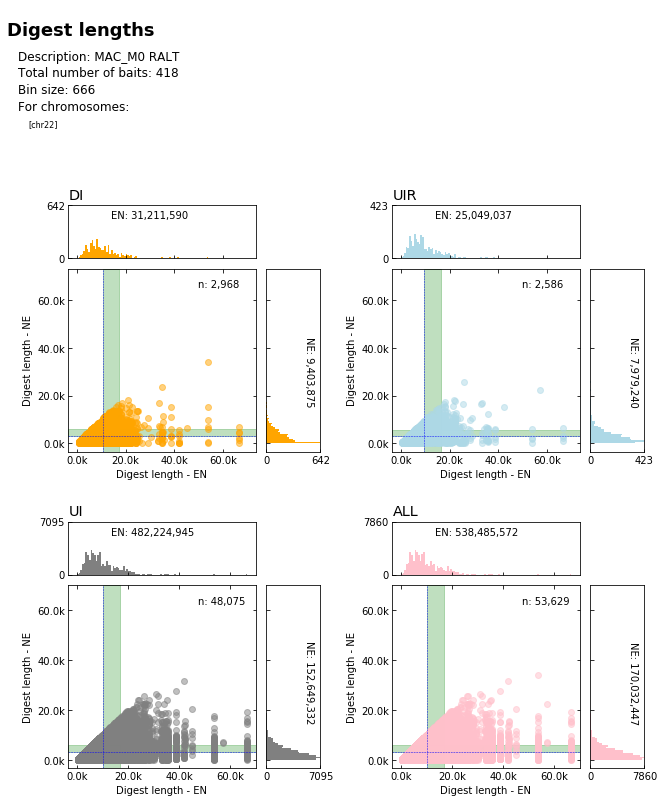

In [62]:
dig_len_pair_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='DIG_LEN',
    chromosomes=['chr22'],
    verbose=True
)
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = dig_len_pair_dict,
    draw_mean_and_sd = True,
    #set_xy_max = 20000,
    sup_title = 'Digest lengths',
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_dig_len_pairs_scatter_plots_with_histograms.pdf'
)

To get an impression of the effects of filtering interactions with extreme digest pairs, repeat the analyzes from this section after uncommenting the relevant line (`remove_digest_length_outliers`) at the beginning.

## Proportion of directed interactions on individual chromosomes  (provisionally)

In [63]:
baited_digest_set.proportion_of_directed_interactions_on_individual_chromosomes()

262
chr21	52843	2093	0.04	0.05	0.48	0.47
418
chr22	53629	2968	0.06	0.05	0.51	0.51


## BaitedDigest key sorted by starting position (provisionally)

In [64]:
sorted_baited_digest_keys = baited_digest_set.get_baited_digest_keys_sorted_by_sta_pos()
for i in sorted_baited_digest_keys['chr22']:
    print(i)

chr22	16818640	16825948
chr22	17004466	17011585
chr22	17078723	17092243
chr22	17116729	17122470
chr22	17158523	17165407
chr22	17247624	17269016
chr22	17358660	17367331
chr22	17625009	17633327
chr22	17771846	17783296
chr22	17976670	17982933
chr22	18021792	18025855
chr22	18076869	18090126
chr22	18107010	18112573
chr22	18145621	18150468
chr22	19111150	19132339
chr22	19141629	19145046
chr22	19146350	19158547
chr22	19175210	19181611
chr22	19290242	19296281
chr22	19427912	19434092
chr22	19434093	19449912
chr22	19472999	19485346
chr22	19526639	19531205
chr22	19704203	19722313
chr22	19722314	19741175
chr22	19756458	19757522
chr22	19940745	19950116
chr22	20003784	20020920
chr22	20029363	20033885
chr22	20083394	20096034
chr22	20111600	20116672
chr22	20116673	20118239
chr22	20124106	20138526
chr22	20181708	20211956
chr22	20246695	20258491
chr22	20262801	20283292
chr22	20388957	20403343
chr22	20412904	20424609
chr22	20434852	20440860
chr22	20494762	20504036
chr22	20520286	20537480
chr22	20720187	2

## Pool datasets

In [ ]:
# Pool ST or HT datasets
PROTOCOL = 'CHC'
MIN_I_DIST = '20000'
if PROTOCOL == 'CHC':
    MIN_I_DIST = '20000'
RPC_RULE = 'ht'
FDR = '01'
pooled_interaction_set = DiachromaticInteractionSet(rpc_rule = RPC_RULE)
for CELL_TYPE_SHORT in ['MK', 'ERY', 'MON', 'NEU', 'MAC_M0', 'MAC_M1', 'MAC_M2']:
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/CHC/JAV_' + CELL_TYPE_SHORT + '_RALT_20000_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    pooled_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

pooled_interaction_set.evaluate_and_categorize_interactions(pval_thresh=0.001, verbose=True)
pooled_interaction_set.select_reference_interactions(verbose=True)
write_report_dict = pooled_interaction_set.write_diachromatic_interaction_file(
    target_file = 'pooled_interaction_set.tsv.gz',
    verbose = True)

## Create file with pseudo unbalanced and associated reference interactions

1. Remove all `DI` interactions and rename all `UIR` interactions to new pseudo `DI` interactions
3. Select refernence interactions `UIR` that have half as many read pairs as compared to the pseudo `DI` interactions
4. Perform alanysis with interaction distances
5. Perform analysis with TAD boundaries

In [14]:
# Load interations
interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

print("[INFO] Removing all 'DI' and 'DIX' interactions and renaming UIR to DI interactions ...")
balanced_interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
for d_inter in interaction_set.interaction_list:
    if d_inter.get_category() == 'DI' or d_inter.get_category() == 'DIX':
        continue
    else:
        if d_inter.get_category() == 'UIR':
            d_inter.set_category('DI')
        balanced_interaction_set._inter_dict[d_inter.key] = d_inter
print("[INFO] ... done.")

# Select reference interactions with greater read pair counts 
balanced_interaction_set.select_reference_interactions(rpc_factor = 0.5, verbose=True)


# Swap DI and UIR again
for d_inter in balanced_interaction_set.interaction_list:
    if d_inter.get_category() == 'DI':
        d_inter.set_category('UIR')
    elif d_inter.get_category() == 'UIR':
        d_inter.set_category('DI') 
    
report_dict = balanced_interaction_set.write_diachromatic_interaction_file(
    target_file = 'PSEUDO_DI' + '/' + CELL_TYPE_SHORT + '_pseudo_di_interaction_set.tsv.gz',
    verbose = True)
    

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../DICer_interactions/ST/FDR005/CHC/JAV_NCD8_RALT_20000_st_fdr0.05_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Set size: 5,137,855
[INFO] ... done.
[INFO] Removing all 'DI' and 'DIX' interactions and renaming UIR to DI interactions ...
[INFO] ... done.
[INFO] Select reference interactions ...
	[INFO] Treating NE and EN as one category ...
	[INFO] First pass: Count directed interactions for different read pair counts ...
	[INFO] Second pass: Select undirected reference interactions for different read pair counts ...
	[INFO] Third pass: Moving DI interactions for which there is no reference to DIX ...
[INFO] ... done.
[INFO] Writing Diachromatic interaction file ...
	[INFO] Required replicat

## Count neighbouring digests

In [85]:
PROTOCOL = 'CHC'
CELL_TYPE_SHORT = 'MAC_M0'
MIN_I_DIST = '20000'
if PROTOCOL == 'CHC':
    MIN_I_DIST = '20000'
RPC_RULE = 'st'
FDR = '05'
if PROTOCOL == 'CHC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/CHC/JAV_' + CELL_TYPE_SHORT + '_RALT_20000_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_CHC_RALT_' + MIN_I_DIST + '_' + RPC_RULE.lower()
if PROTOCOL == 'HC_POOLED':
    INTERACTION_FILE = '../DICer_interactions/HT/FDR005/HC/20000/JAV_ALL_HC_RALL_ALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + 'POOLED_HC_FDR005' + '_HC_RALT_20000_' + RPC_RULE.lower()
if PROTOCOL == 'HC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/HC/' + MIN_I_DIST + '/JAV_' + CELL_TYPE_SHORT + '_HC_RALT_' + MIN_I_DIST + '_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_HC_RALT_'  + MIN_I_DIST + '_' + RPC_RULE.lower()

# Load interations
interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../DICer_interactions/ST/FDR005/CHC/JAV_MAC_M0_RALT_20000_st_fdr0.05_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Set size: 5,534,503
[INFO] ... done.


In [86]:
print("[INFO] Getting digest sets...")
from_digests_dict = {
    'DIX': set(),
    'DI': set(),
    'UIR': set(),
    'UI': set(),
    'ALL': set(),
}
to_digests_dict = {
    'DIX': set(),
    'DI': set(),
    'UIR': set(),
    'UI': set(),
    'ALL': set(),
}
for d_inter in interaction_set.interaction_list:
    from_digests_dict[d_inter.get_category()].add(d_inter.chrA + '\t' + str(d_inter.fromA))
    from_digests_dict[d_inter.get_category()].add(d_inter.chrB + '\t' + str(d_inter.fromB))
    to_digests_dict[d_inter.get_category()].add(d_inter.chrA + '\t' + str(d_inter.toA))
    to_digests_dict[d_inter.get_category()].add(d_inter.chrB + '\t' + str(d_inter.toB))
    from_digests_dict['ALL'].add(d_inter.chrA + '\t' + str(d_inter.fromA))
    from_digests_dict['ALL'].add(d_inter.chrB + '\t' + str(d_inter.fromB))
    to_digests_dict['ALL'].add(d_inter.chrA + '\t' + str(d_inter.toA))
    to_digests_dict['ALL'].add(d_inter.chrB + '\t' + str(d_inter.toB))
print("[INFO] ...done.")

[INFO] Getting digest sets ...
[INFO] ... done.


In [87]:
print("[INFO] Counting neighbouring digests ...")
for i_cat in ['DIX','DI','UIR','UI','ALL']:
    print(i_cat)
    from_digest_set = from_digests_dict[i_cat]
    to_digest_set = to_digests_dict[i_cat]
    neighbour_cnt = 0
    for to_digest in to_digest_set:
        chrom, pos = to_digest.split('\t')
        from_digest_key = chrom + '\t' + str(int(pos) + 1)
        if from_digest_key in from_digest_set:
            neighbour_cnt += 1
            
    print(len(from_digest_set))
    print(len(to_digest_set))
    print('Number of neighbours: ' + str(neighbour_cnt))
    print(neighbour_cnt/len(to_digest_set))
    print('-------')
print("[INFO] ... done.")

[INFO] Counting neighbouring digests ...
DIX
632
632
Number of neighbours: 47
0.07436708860759493
-------
DI
145300
145300
Number of neighbours: 53558
0.3686028905712319
-------
UIR
192283
192283
Number of neighbours: 75341
0.3918235101387018
-------
UI
704032
704032
Number of neighbours: 658628
0.9355086132448525
-------
ALL
710914
710914
Number of neighbours: 669247
0.9413895351617777
-------
[INFO] ... done.


In [ ]:
DI
485034
485034
332024
0.6845375788089082

UIR
485526
485526
341233
0.7028109720179764

UI
665985
665985
597178
0.8966838592460791